<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Aging/AgingCountersTestStandUVaBottom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init and load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy.polynomial.polynomial as poly
import numpy as np
import scipy
from scipy.optimize import curve_fit
import statistics
import math
from datetime import datetime, timedelta
plt.rcParams.update({'figure.max_open_warning': 0})
import itertools as it



In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=17Yjr34rnNR0GOWfxkGhcwCjZwhnOrDCT

Downloading...
From: https://drive.google.com/uc?id=17Yjr34rnNR0GOWfxkGhcwCjZwhnOrDCT
To: /content/ScanningData_NaturalAgingBottom.txt
100% 2.21M/2.21M [00:00<00:00, 70.4MB/s]


In [35]:
filename = 'ScanningData_NaturalAgingBottom.txt'
with open(filename) as f:
  rows = f.readlines()
  cols = [i for i in range(len(rows[len(rows) - 1].split()))] #this reads the length of the last line and uses that as the number of columns so you don't have to count the number
  data = pd.read_csv(filename, names=cols, sep="\t", header=None, engine='python')
  data[1] = pd.to_datetime(data[1])
  data.set_index(1, inplace=True)
data = data[data.iloc[:, 10:60].gt(0).all(axis=1)]
data = data[data.iloc[:, 67].gt(0)]

data.index.names = ['Date']
data.drop(0, axis=1, inplace=True)
data.rename({2: 'source'}, axis=1, inplace=True)

column_renames_dict = {}
for col in data.columns[1:].values:
  column_renames_dict[col] = col-3
data.rename(columns=column_renames_dict, inplace=True)
data = data.reset_index()

In [36]:
data_signal = data.query('source==1')
data_pedest = data.query('source==0')

In [5]:
def funcC(x, a, b, c): #this is an exponential plus a constant
    return a * np.exp(-b * x) + c
def expo(x, a, b): #this is an exponential
    return a * np.exp(-b * x)
def lin_func(x, a, b): #a linear function
    return a + b * x
def pol0(x, a): #a straight line function
    return a 
def pol2(x, a, b, c): #a second order polynomial
  return (a*x**2) + b*x + c
pd.set_option('max_columns', None)

#Make plots

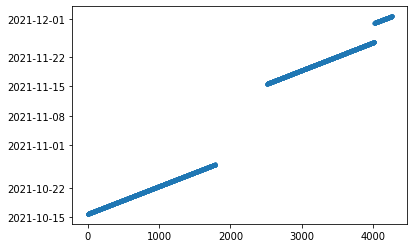

In [14]:
plt.plot(data_signal.Date, '.')

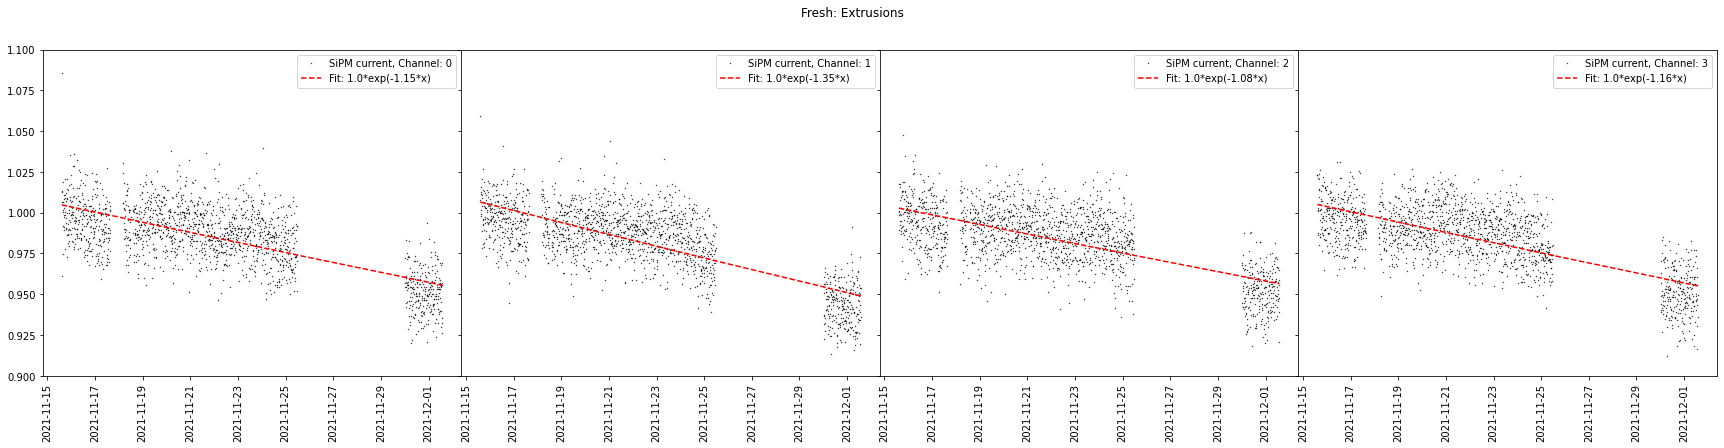

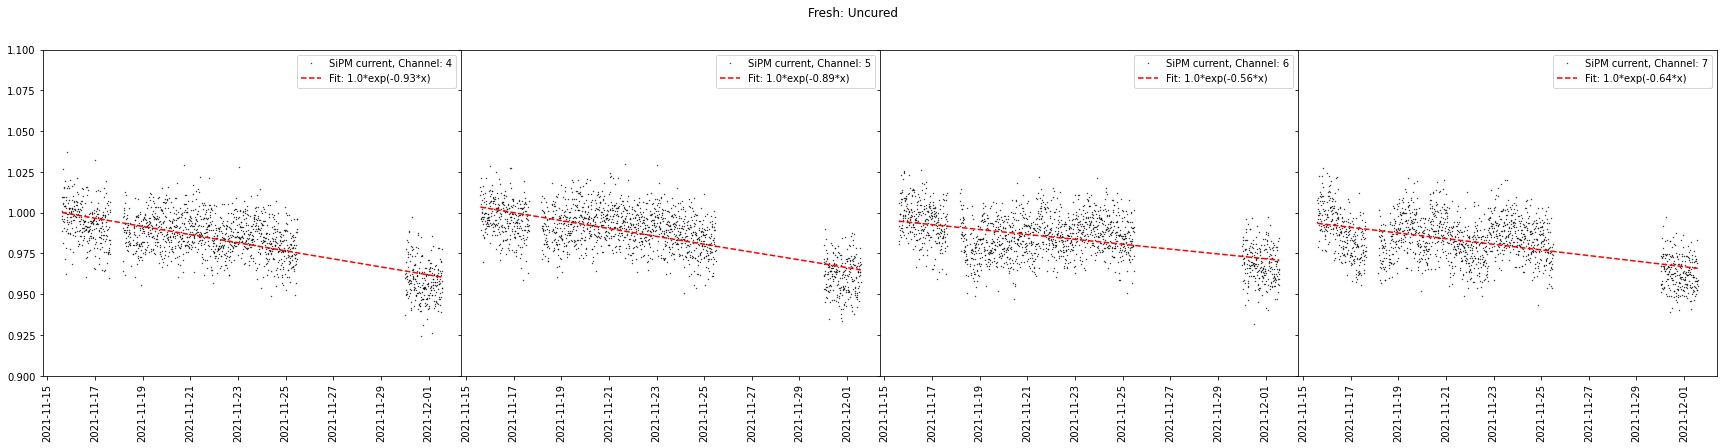

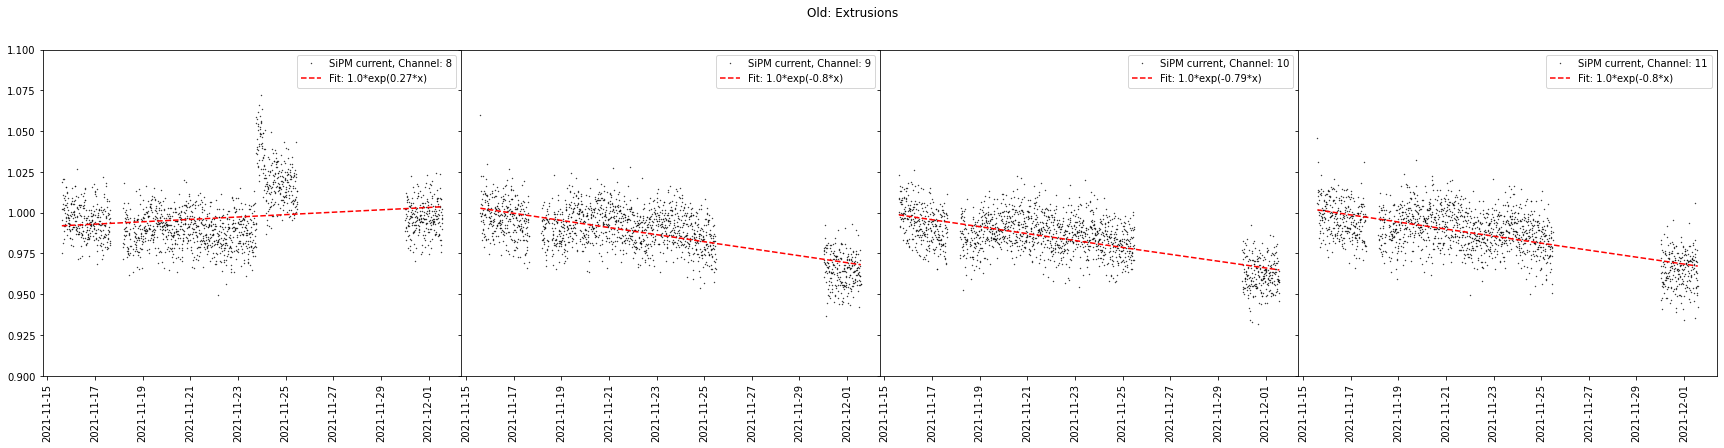

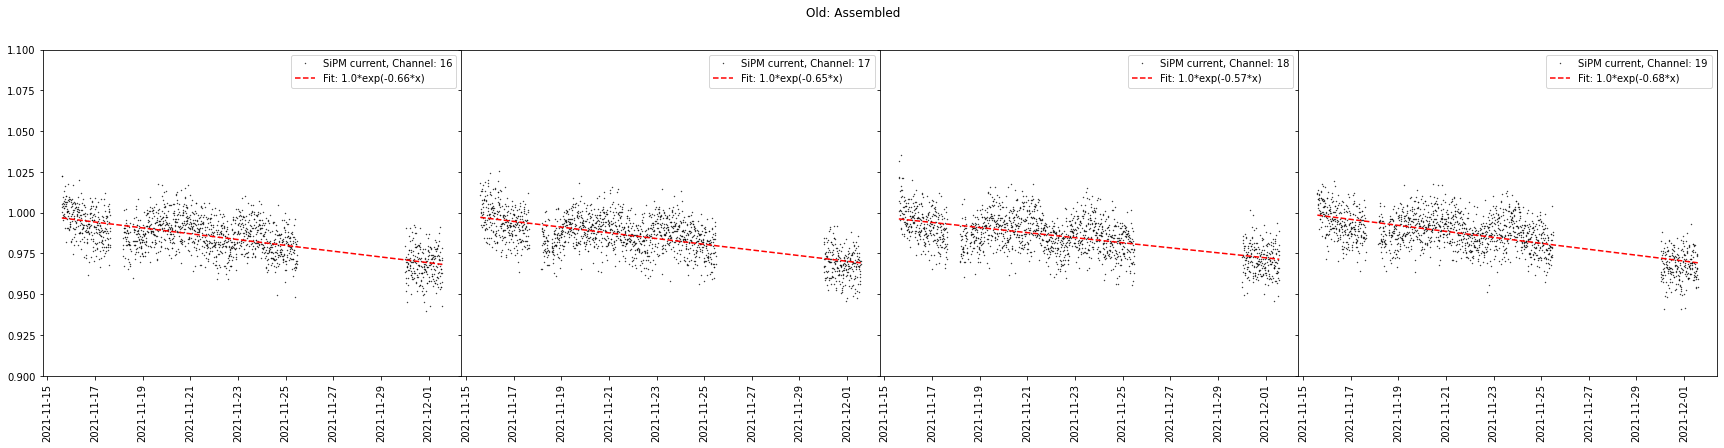

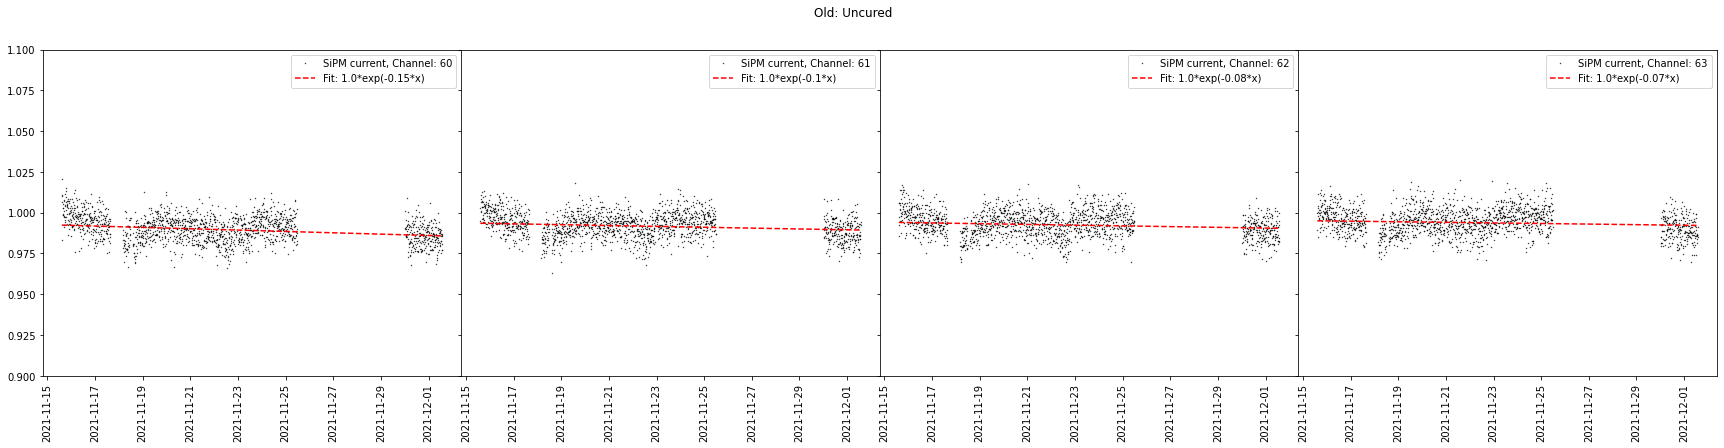

In [16]:
label = ''
data_ = data_signal.loc[ (data_signal[67]>21) & (data_signal[67]<22)  & (data_signal.index>2000)]
X = (data_.Date -  data_.Date.to_numpy()[0]).astype('timedelta64[h]')/(365*24) #divides days into years

for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):
  if chan>=0 and chan<4:
    label='Fresh: Extrusions'
  if chan>=4 and chan<8:
    label='Fresh: Uncured'
  if chan>=8 and chan<12:
    label='Old: Extrusions'
  if chan>=16 and chan<20:
    label='Old: Assembled'
  if chan>=60 and chan<64:
    label='Old: Uncured'

    
  pedestal = 0.2
  y = data_[chan] - pedestal #subtracts the pedestal value
  max_current = y[0:100].mean() 
  y = y/max_current#normalizing

  popt, pcov = curve_fit(expo, X, y, p0=(1, 0.05))

  if(chan%4==0):
    fig, axs = plt.subplots(1,4, figsize=(30, 6), sharey=True);
    fig.subplots_adjust(wspace=0)
  fig.suptitle(label)
  axs[chan%4].plot(data_.Date, y, 'k.', label="SiPM current, Channel: %d"%chan, markersize=0.75);
  axs[chan%4].plot(data_.Date, expo(X, *popt), 'r--', label="Fit: " + str(round(popt[0], 1)) + "*exp("+str(-1*round(popt[1],2))+"*x)"); #fits an exponential to the function
  axs[chan%4].legend()
  axs[chan%4].set_ylim(0.9,1.1);
  axs[chan%4].tick_params(axis='x', labelrotation = 90);

<Figure size 432x288 with 0 Axes>

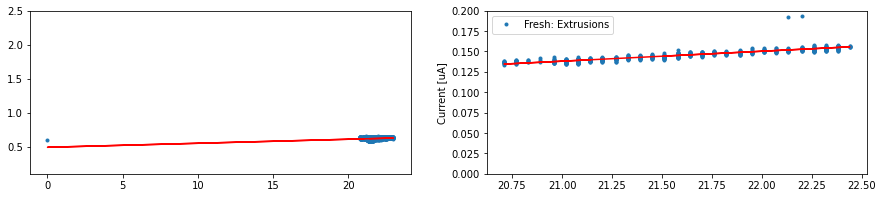

<Figure size 432x288 with 0 Axes>

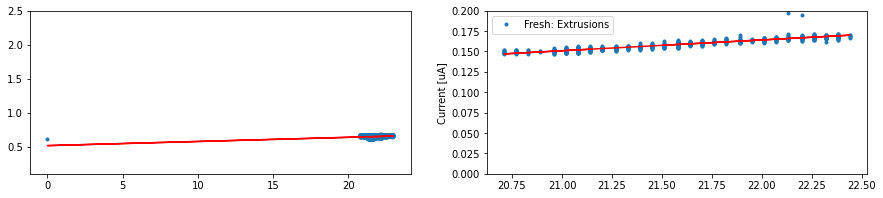

<Figure size 432x288 with 0 Axes>

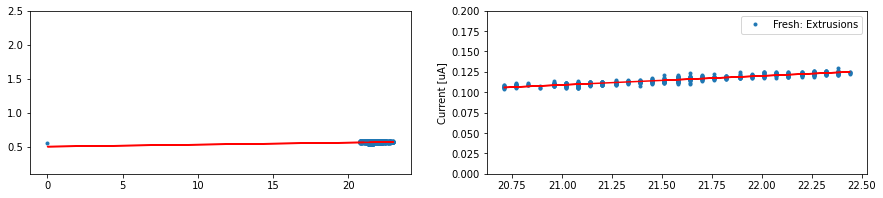

<Figure size 432x288 with 0 Axes>

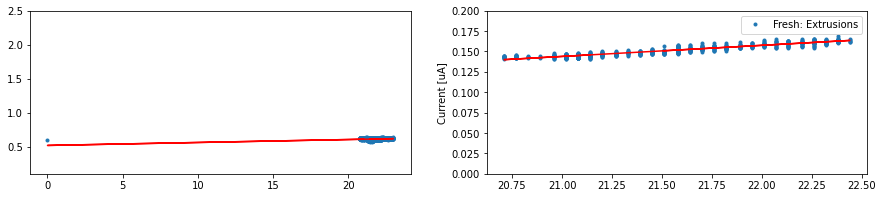

<Figure size 432x288 with 0 Axes>

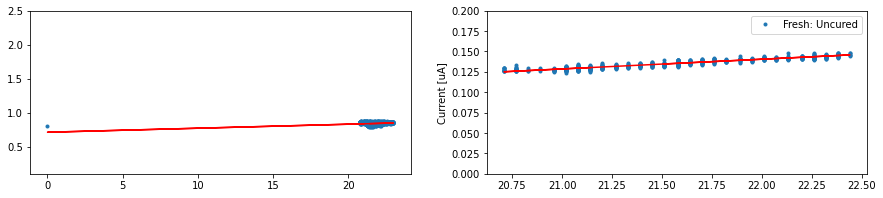

<Figure size 432x288 with 0 Axes>

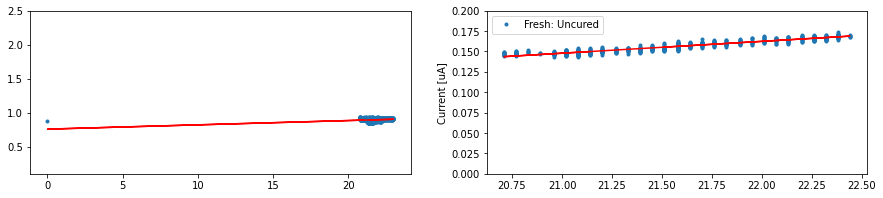

<Figure size 432x288 with 0 Axes>

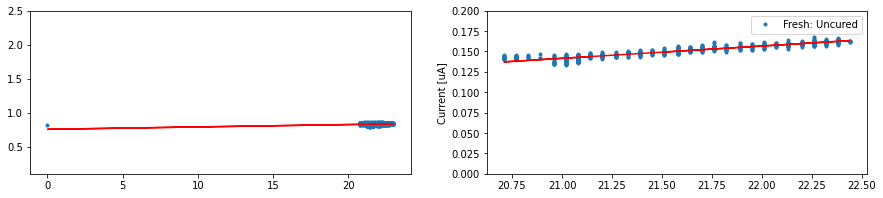

<Figure size 432x288 with 0 Axes>

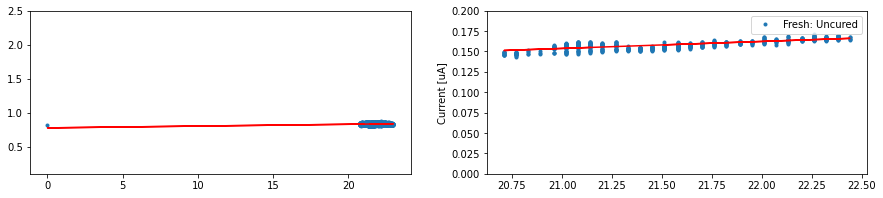

<Figure size 432x288 with 0 Axes>

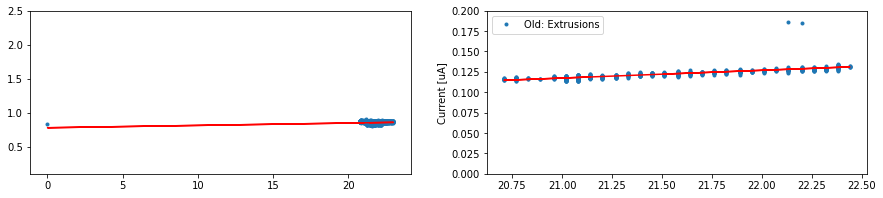

<Figure size 432x288 with 0 Axes>

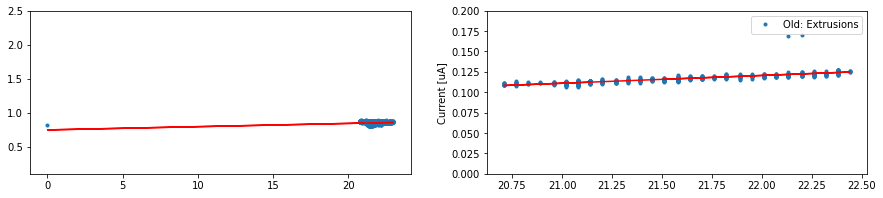

<Figure size 432x288 with 0 Axes>

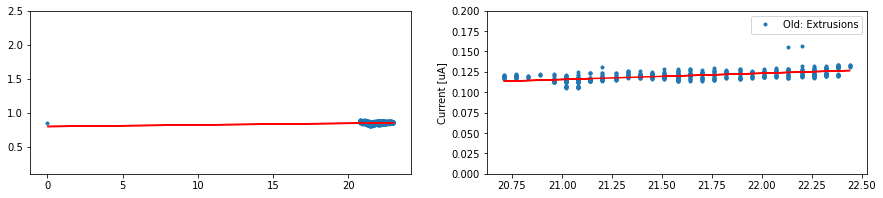

<Figure size 432x288 with 0 Axes>

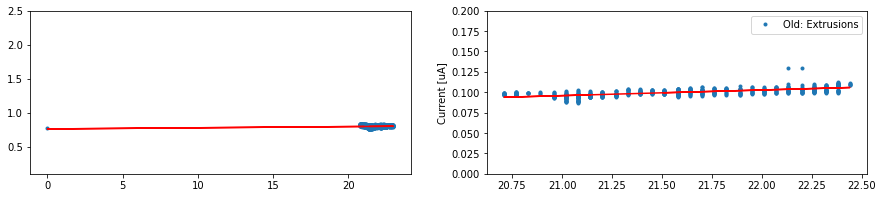

<Figure size 432x288 with 0 Axes>

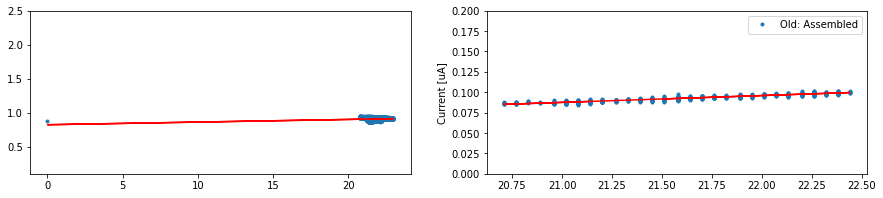

<Figure size 432x288 with 0 Axes>

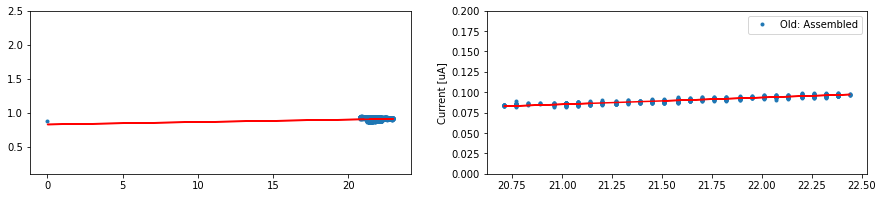

<Figure size 432x288 with 0 Axes>

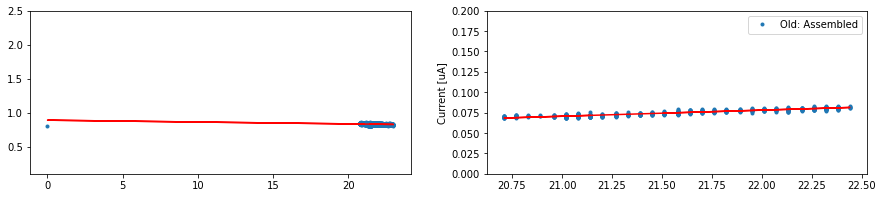

<Figure size 432x288 with 0 Axes>

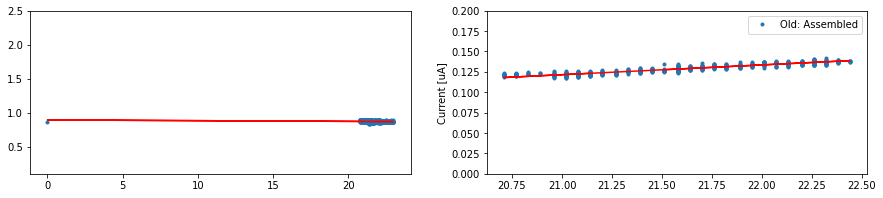

<Figure size 432x288 with 0 Axes>

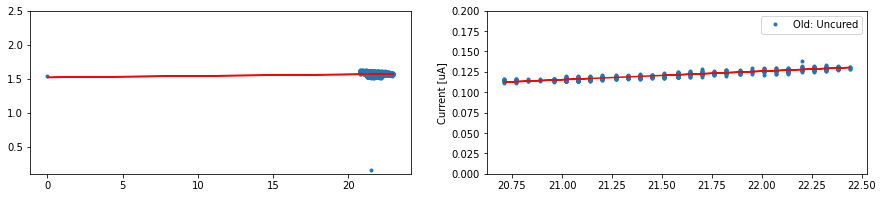

<Figure size 432x288 with 0 Axes>

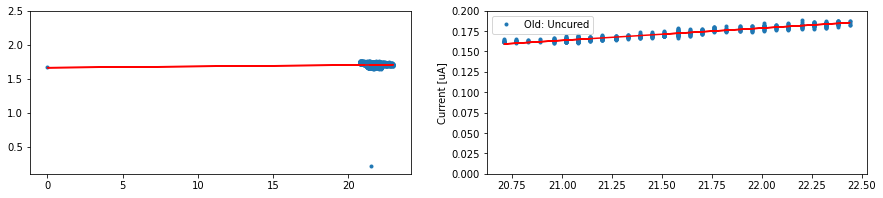

<Figure size 432x288 with 0 Axes>

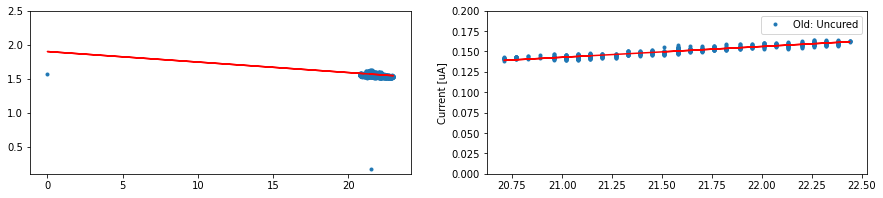

<Figure size 432x288 with 0 Axes>

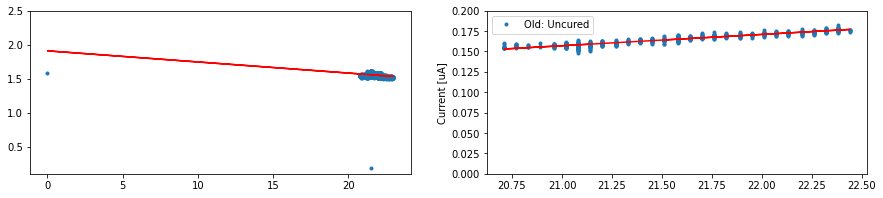

In [7]:
for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):
  plt.figure()

  if chan>=0 and chan<4:
    label='Fresh: Extrusions'
  if chan>=4 and chan<8:
    label='Fresh: Uncured'
  if chan>=8 and chan<12:
    label='Old: Extrusions'
  if chan>=16 and chan<20:
    label='Old: Assembled'
  if chan>=60 and chan<64:
    label='Old: Uncured'

  fig, axs = plt.subplots(1,2, figsize=(15, 3));
  axs[0].plot(data_signal[67], data_signal[chan], '.', label=label);
  popt, pcov = curve_fit(lin_func, data_signal[67], data_signal[chan], p0=(1, 0.05))
  axs[0].plot(data_signal[67], lin_func(data_signal[67], *popt), 'r-')
  axs[0].set_ylim(0.1, 2.5)

  axs[1].plot(data_pedest[67], data_pedest[chan], '.', label=label);
  popt, pcov = curve_fit(lin_func, data_pedest[67], data_pedest[chan], p0=(1, 0.05))
  axs[1].plot(data_pedest[67], lin_func(data_pedest[67], *popt), 'r-')
  plt.ylabel('Current [uA]')
  axs[1].set_ylim(0.0, 0.2)
  plt.legend()


Text(0.5, 0, 'Temp [C]')

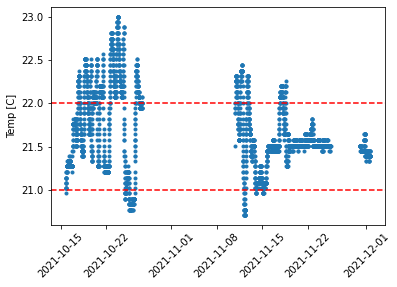

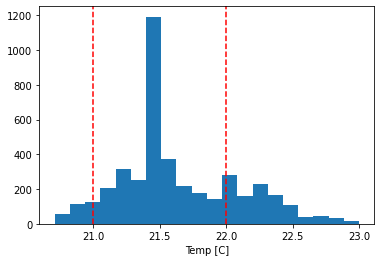

In [38]:
plt.plot(data.Date, data[67], '.', label='Temp [C]')
plt.axhline(y=21, color='r', linestyle='--')
plt.axhline(y=22, color='r', linestyle='--')
plt.xticks(rotation = 45);
plt.ylabel('Temp [C]')

plt.figure()
plt.hist(data[67], bins=20, label='Temp [C]');
plt.axvline(x=21, color='r', linestyle='--')
plt.axvline(x=22, color='r', linestyle='--')
plt.xlabel('Temp [C]')